# World of Supply

A simulation environment for multi-echelon supply chain optimization problems. 

In [1]:
import numpy as np
from tqdm import tqdm as tqdm
import importlib

import world_of_supply_tools as wst
importlib.reload(wst)

wst.print_hardware_status()

2020-05-25 16:52:06,535	INFO resource_spec.py:212 -- Starting Ray with 69.68 GiB memory available for workers and up to 33.86 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Number of CPU cores: 16
Memory: MemTotal:       125815156 kB
MemFree:        112164564 kB
MemAvailable:   117175888 kB

GPU status: 00:1e.0 VGA compatible controller: NVIDIA Corporation GM204GL [Tesla M60] (rev a1)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7365895929573511767
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10280327524487563186
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14888553971994882446
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7207341280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6441260716524985604
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


2020-05-25 16:52:06,924	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


ray.get_gpu_ids(): []
CUDA_VISIBLE_DEVICES: None


# Core Simulation Logic and Rendering

In this section, we test the core simulator and renderer (without RL adapters and integrations).

In [ ]:
import world_of_supply_environment as ws
import world_of_supply_renderer as wsr
import world_of_supply_tools as wst
for module in [ws, wsr, wst]:
    importlib.reload(module)
        
# Measure the simulation rate, steps/sec
eposod_len = 1000
n_episods = 10
world = ws.WorldBuilder.create()
tracker = wst.SimulationTracker(eposod_len, n_episods, world.facilities.keys())
with tqdm(total=eposod_len * n_episods) as pbar:
    for i in range(n_episods):
        world = ws.WorldBuilder.create()
        policy = ws.SimpleControlPolicy()
        for t in range(eposod_len):
            outcome = world.act(policy.compute_control(world))
            tracker.add_sample(i, t, world.economy.global_balance().total(), 
                               {k: v.total() for k, v in outcome.facility_step_balance_sheets.items() } )
            pbar.update(1)        
tracker.render()
    
# Test rendering
renderer = wsr.AsciiWorldRenderer()
frame_seq = []
world = ws.WorldBuilder.create()
policy = ws.SimpleControlPolicy()
for epoch in tqdm(range(300)):
    frame = renderer.render(world)
    frame_seq.append(np.asarray(frame))
    world.act(policy.compute_control(world))

print('Rendering the animation...')
wsr.AsciiWorldRenderer.plot_sequence_images(frame_seq)

# Policy Training

In this section, we run RLlib policy trainers. These trainers evaluate the hand coded policy, learn a new policy from scrath, or learn a new policy by playing against the hand coded policy.

In [ ]:
import world_of_supply_rllib_models as wsm
importlib.reload(wsm)
import world_of_supply_rllib as wsrl
importlib.reload(wsrl)
import world_of_supply_rllib_training as wsrt
importlib.reload(wsrt)

wsrt.print_model_summaries()

# Policy training
#trainer = wsrt.play_baseline(n_iterations = 1)
trainer = wsrt.train_ppo(n_iterations = 400)

2020-05-25 16:52:32,554	INFO resource_spec.py:212 -- Starting Ray with 69.63 GiB memory available for workers and up to 33.83 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-25 16:52:32,896	INFO services.py:1148 -- View the Ray dashboard at localhost:8266
2020-05-25 16:52:33,404	INFO resource_spec.py:212 -- Starting Ray with 69.63 GiB memory available for workers and up to 33.83 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-25 16:52:33,748	INFO services.py:1148 -- View the Ray dashboard at localhost:8266
2020-05-25 16:52:33,946	INFO catalog.py:291 -- Wrapping <class 'world_of_supply_rllib_models.FacilityNet'> as None
2020-05-25 16:52:35,527	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-25 16:52:35,555	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level':

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_in (InputLayer)             [(None,)]            0                                            
__________________________________________________________________________________________________
tf_op_layer_SequenceMask/Max (T [()]                 0           seq_in[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_SequenceMask/Maximu [()]                 0           tf_op_layer_SequenceMask/Max[0][0
__________________________________________________________________________________________________
tf_op_layer_SequenceMask/Expand [(None, 1)]          0           seq_in[0][0]                     
______________________________________________________________________________________________

2020-05-25 16:52:48,965	INFO trainable.py:180 -- _setup took 13.412 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-05-25 16:52:48,966	INFO trainable.py:217 -- Getting current IP.



== Iteration 0 ==
- policy map: {'SteelFactoryCell_1p': 'baseline_producer', 'SteelFactoryCell_1c': 'baseline_consumer', 'LumberFactoryCell_2p': 'baseline_producer', 'LumberFactoryCell_2c': 'baseline_consumer', 'ToyFactoryCell_3p': 'ppo_producer', 'ToyFactoryCell_3c': 'ppo_consumer', 'ToyFactoryCell_4p': 'ppo_producer', 'ToyFactoryCell_4c': 'ppo_consumer', 'ToyFactoryCell_5p': 'ppo_producer', 'ToyFactoryCell_5c': 'ppo_consumer', 'WarehouseCell_6p': 'baseline_producer', 'WarehouseCell_6c': 'baseline_consumer', 'WarehouseCell_7p': 'baseline_producer', 'WarehouseCell_7c': 'baseline_consumer', 'RetailerCell_8p': 'baseline_producer', 'RetailerCell_8c': 'baseline_consumer', 'RetailerCell_9p': 'baseline_producer', 'RetailerCell_9c': 'baseline_consumer'}
Iteration 0 took [406.69] seconds
- date: 2020-05-25_16-56-37
- episode_len_mean: 50.0
- episodes_total: 520
- episode_reward_max: 886667.9999999998
- episode_reward_mean: 164663.87153846156
- episode_reward_min: -83569.20000000004
- timestep

# Policy Evaluation

In this section, we evaluate the trained policy.

### Rendering One Episod for the Trained Policy

2020-05-25 11:55:26,992	INFO resource_spec.py:212 -- Starting Ray with 69.04 GiB memory available for workers and up to 33.59 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-25 11:55:27,555	INFO services.py:1148 -- View the Ray dashboard at localhost:8266
  0%|          | 0/1000 [00:00<?, ?it/s]

Environment: Producer action space MultiDiscrete([8 6]), Consumer action space MultiDiscrete([3 3 6]), Observation space Box(56,)


100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


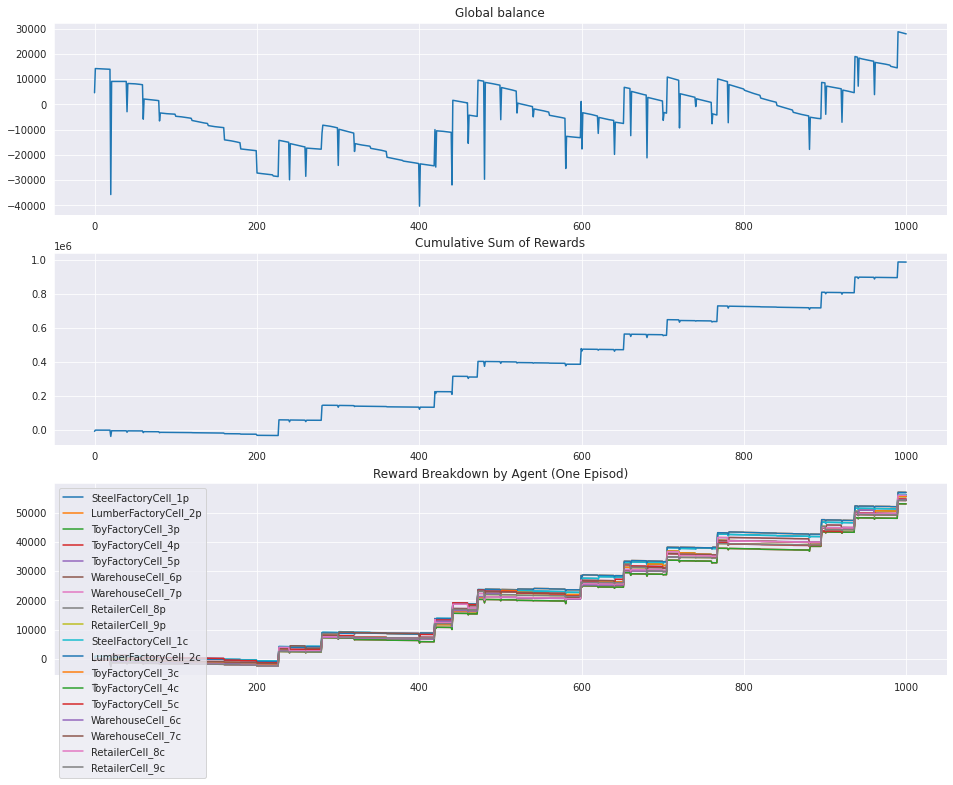

Rendering the animation...


<Figure size 1420x1712 with 0 Axes>

In [6]:
import world_of_supply_renderer as wsren
import world_of_supply_tools as wst
import world_of_supply_rllib as wsrl
import world_of_supply_rllib_training as wstr
for module in [wsren, wst, wsrl, wstr]:
    importlib.reload(module)

# Parameters of the tracing simulation
policy_mode = 'trained'   # 'baseline' or 'trained'
episod_duration = 1000
steps_to_render = (0, episod_duration)  # (0, episod_duration) or None

# Create the environment
renderer = wsren.AsciiWorldRenderer()
frame_seq = []
env_config_for_rendering = wstr.env_config.copy()
env_config_for_rendering.update({
    'downsampling_rate': 1
})
env = wsrl.WorldOfSupplyEnv(env_config_for_rendering)
env.set_iteration(1, 1)
print(f"Environment: Producer action space {env.action_space_producer}, Consumer action space {env.action_space_consumer}, Observation space {env.observation_space}")
states = env.reset()
infos = None
    
def load_policy(agent_id):
    if policy_mode == 'baseline':
        if wsrl.Utils.is_producer_agent(agent_id):
            return wsrl.ProducerSimplePolicy(env.observation_space, env.action_space_producer, wsrl.SimplePolicy.get_config_from_env(env))
        elif wsrl.Utils.is_consumer_agent(agent_id):
            return wsrl.ConsumerSimplePolicy(env.observation_space, env.action_space_consumer, wsrl.SimplePolicy.get_config_from_env(env))
        else:
            raise Exception(f'Unknown agent type {agent_id}')
    
    if policy_mode == 'trained':
        policy_map = wstr.policy_mapping_global.copy()
        wstr.update_policy_map(policy_map, 0, 0)     # apply all updates
        return trainer.get_policy(wstr.create_policy_mapping_fn(policy_map)(agent_id))

policies = {}
rnn_states = {}
for agent_id in states.keys():
    policies[agent_id] = load_policy(agent_id)
    rnn_states[agent_id] = policies[agent_id].get_initial_state()
    
# Simulation loop
tracker = wst.SimulationTracker(episod_duration, 1, env.agent_ids())
for epoch in tqdm(range(episod_duration)):
    
    action_dict = {}
    if epoch % wstr.env_config['downsampling_rate'] == 0:
        for agent_id, state in states.items():
            policy = policies[agent_id]
            rnn_state = rnn_states[agent_id]
            if infos is not None and agent_id in infos:
                action_dict[agent_id], rnn_state, _ = policy.compute_single_action( state, info=infos[agent_id], state=rnn_state ) 
            else:
                action_dict[agent_id], rnn_state, _ = policy.compute_single_action( state, state=rnn_state )   
   
    states, rewards, dones, infos = env.step(action_dict)
    tracker.add_sample(0, epoch, env.world.economy.global_balance().total(), rewards)
    
    if steps_to_render is not None and epoch >= steps_to_render[0] and epoch < steps_to_render[1]:
        frame = renderer.render(env.world)
        frame_seq.append(np.asarray(frame))
 
tracker.render()

if steps_to_render is not None:
    print('Rendering the animation...')
    wsren.AsciiWorldRenderer.plot_sequence_images(frame_seq)